In [8]:
import tensorflow as tf
import numpy as np
import timeit

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

import os
os.environ["KMP_WARNINGS"] = "FALSE" 


import scipy
import scipy.io
import time

import sys

import scipy
import scipy.io
import time


import logging

import os.path
import shutil
from datetime import datetime
import pickle
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y
    

######################################################################################################
def u(x, a_1, a_2):
    return np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

def u_xx(x, a_1, a_2):
    return - (a_1 * np.pi) ** 2 * np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

def u_yy(x, a_1, a_2):
    return - (a_2 * np.pi) ** 2 * np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

# Forcing
def f(x, a_1, a_2, lam):
    return u_xx(x, a_1, a_2) + u_yy(x, a_1, a_2) + lam * u(x, a_1, a_2)

def operator(u, x1, x2, lam, sigma_x1=1.0, sigma_x2=1.0):
    u_x1 = tf.gradients(u, x1)[0] / sigma_x1
    u_x2 = tf.gradients(u, x2)[0] / sigma_x2
    u_xx1 = tf.gradients(u_x1, x1)[0] / sigma_x1
    u_xx2 = tf.gradients(u_x2, x2)[0] / sigma_x2
    residual = u_xx1 + u_xx2 + lam * u
    return residual
#######################################################################################################

class Helmholtz2D:
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, sess):
        # Normalization constants


        self.mode = mode

        self.dirname, logpath = self.make_output_dir()
        self.logger = self.get_logger(logpath)     

        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x1, self.sigma_x1 = self.mu_X[0], self.sigma_X[0]
        self.mu_x2, self.sigma_x2 = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Helmoholtz constant
        self.lam = tf.constant(lam, dtype=tf.float32)

        # Mode
        self.model = mode

        # Record stiff ratio
        # self.stiff_ratio = stiff_ratio

        # Adaptive constant
        self.beta = 0.9
        self.adaptive_constant_val = np.array(1.0)

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # if mode in ['M3', 'M4']:
        #     # Initialize encoder weights and biases
        #     self.encoder_weights_1 = self.xavier_init([2, layers[1]])
        #     self.encoder_biases_1 = self.xavier_init([1, layers[1]])

        #     self.encoder_weights_2 = self.xavier_init([2, layers[1]])
        #     self.encoder_biases_2 = self.xavier_init([1, layers[1]])

        # Define Tensorflow session
        self.sess = sess #tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph
        self.x1_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        # Define placeholder for adaptive constant
        self.adaptive_constant_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_val.shape)

        # Evaluate predictions
        self.u_bc1_pred = self.net_u(self.x1_bc1_tf, self.x2_bc1_tf)
        self.u_bc2_pred = self.net_u(self.x1_bc2_tf, self.x2_bc2_tf)
        self.u_bc3_pred = self.net_u(self.x1_bc3_tf, self.x2_bc3_tf)
        self.u_bc4_pred = self.net_u(self.x1_bc4_tf, self.x2_bc4_tf)

        self.u_pred = self.net_u(self.x1_u_tf, self.x2_u_tf)
        self.r_pred = self.net_r(self.x1_r_tf, self.x2_r_tf)

        # Boundary loss
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_tf - self.u_bc1_pred))
        self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_tf - self.u_bc2_pred))
        self.loss_bc3 = tf.reduce_mean(tf.square(self.u_bc3_tf - self.u_bc3_pred))
        self.loss_bc4 = tf.reduce_mean(tf.square(self.u_bc4_tf - self.u_bc4_pred))
        self.loss_bcs = self.adaptive_constant_tf * (self.loss_bc1 + self.loss_bc2 + self.loss_bc3 + self.loss_bc4)

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_tf - self.r_pred))

        # Total loss
        self.loss = self.loss_res + self.loss_bcs

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step, 1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        self.loss_tensor_list = [self.loss ,  self.loss_res,  self.loss_bc1 , self.loss_bc2 , self.loss_bc3, self.loss_bc4] 
        self.loss_list = ["total loss" , "loss_res" , "loss_bc1", "loss_bc2", "loss_bc3", "loss_bc4"] 

        self.epoch_loss = dict.fromkeys(self.loss_list, 0)
        self.loss_history = dict((loss, []) for loss in self.loss_list)
        # Logger
        self.loss_bcs_log = []
        self.loss_res_log = []
        # self.saver = tf.train.Saver()

        # Generate dicts for gradients storage
        self.dict_gradients_res_layers = self.generate_grad_dict()
        self.dict_gradients_bcs_layers = self.generate_grad_dict()

        # Gradients Storage
        self.grad_res = []
        self.grad_bcs = []
        for i in range(len(self.layers) - 1):
            self.grad_res.append(tf.gradients(self.loss_res, self.weights[i])[0])
            self.grad_bcs.append(tf.gradients(self.loss_bcs, self.weights[i])[0])

        # Compute and store the adaptive constant
        self.adpative_constant_log = []
        self.adaptive_constant_list = []
        
        self.max_grad_res_list = []
        self.mean_grad_bcs_list = []
        
        for i in range(len(self.layers) - 1):
            self.max_grad_res_list.append(tf.reduce_max(tf.abs(self.grad_res[i]))) 
            self.mean_grad_bcs_list.append(tf.reduce_mean(tf.abs(self.grad_bcs[i])))
        
        self.max_grad_res = tf.reduce_max(tf.stack(self.max_grad_res_list))
        self.mean_grad_bcs = tf.reduce_mean(tf.stack(self.mean_grad_bcs_list))
        self.adaptive_constant = self.max_grad_res / self.mean_grad_bcs

        # # Stiff Ratio
        # if self.stiff_ratio:
        #     self.Hessian, self.Hessian_bcs, self.Hessian_res = self.get_H_op()
        #     self.eigenvalues, _ = tf.linalg.eigh(self.Hessian)
        #     self.eigenvalues_bcs, _ = tf.linalg.eigh(self.Hessian_bcs)
        #     self.eigenvalues_res, _ = tf.linalg.eigh(self.Hessian_res)

        #     self.eigenvalue_log = []
        #     self.eigenvalue_bcs_log = []
        #     self.eigenvalue_res_log = []

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

     # Create dictionary to store gradients
    def generate_grad_dict(self, layers):
        num = len(layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict

    # Save gradients
    def save_gradients(self, tf_dict):
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res_value, grad_bcs_value = self.sess.run([self.grad_res[i], self.grad_bcs[i]], feed_dict=tf_dict)

            # save gradients of loss_res and loss_bcs
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res_value.flatten())
            self.dict_gradients_bcs_layers['layer_' + str(i + 1)].append(grad_bcs_value.flatten())
        return None

    # Compute the Hessian
    def flatten(self, vectors):
        return tf.concat([tf.reshape(v, [-1]) for v in vectors], axis=0)

    def get_Hv(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss, self.weights))
        vprod = tf.math.multiply(loss_gradients, tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_res(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_res,   self.weights))
        vprod = tf.math.multiply(loss_gradients, tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod,  self.weights))
        return Hv_op

    def get_Hv_bcs(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_bcs, self.weights))
        vprod = tf.math.multiply(loss_gradients, tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_H_op(self):
        self.P = self.flatten(self.weights).get_shape().as_list()[0]
        H = tf.map_fn(self.get_Hv, tf.eye(self.P, self.P), dtype='float32')
        H_bcs = tf.map_fn(self.get_Hv_bcs, tf.eye(self.P, self.P),  dtype='float32')
        H_res = tf.map_fn(self.get_Hv_res, tf.eye(self.P, self.P),  dtype='float32')

        return H, H_bcs, H_res

    # Xavier initialization
    def xavier_init(self,size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H):
        if self.model in ['M1', 'M2']:
            num_layers = len(self.layers)
            for l in range(0, num_layers - 2):
                W = self.weights[l]
                b = self.biases[l]
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
            W = self.weights[-1]
            b = self.biases[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

        if self.model in ['M3', 'M4']:
            num_layers = len(self.layers)
            encoder_1 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_1), self.encoder_biases_1))
            encoder_2 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_2), self.encoder_biases_2))

            for l in range(0, num_layers - 2):
                W = self.weights[l]
                b = self.biases[l]
                H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
                    tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_2)

            W = self.weights[-1]
            b = self.biases[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

    # Forward pass for u
    def net_u(self, x1, x2):
        u = self.forward_pass(tf.concat([x1, x2], 1))
        return u

    # Forward pass for residual
    def net_r(self, x1, x2):
        u = self.net_u(x1, x2)
        residual = self.operator(u, x1, x2,
                                 self.lam,
                                 self.sigma_x1,
                                 self.sigma_x2)
        return residual

    # Feed minibatch
    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            X_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
            X_bc4_batch, u_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], batch_size)

            # Fetch residual mini-batch
            X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x1_bc1_tf: X_bc1_batch[:, 0:1], self.x2_bc1_tf: X_bc1_batch[:, 1:2],
                       self.u_bc1_tf: u_bc1_batch,
                       self.x1_bc2_tf: X_bc2_batch[:, 0:1], self.x2_bc2_tf: X_bc2_batch[:, 1:2],
                       self.u_bc2_tf: u_bc2_batch,
                       self.x1_bc3_tf: X_bc3_batch[:, 0:1], self.x2_bc3_tf: X_bc3_batch[:, 1:2],
                       self.u_bc3_tf: u_bc3_batch,
                       self.x1_bc4_tf: X_bc4_batch[:, 0:1], self.x2_bc4_tf: X_bc4_batch[:, 1:2],
                       self.u_bc4_tf: u_bc4_batch,
                       self.x1_r_tf: X_res_batch[:, 0:1], self.x2_r_tf: X_res_batch[:, 1:2], self.r_tf: f_res_batch,
                       self.adaptive_constant_tf:  self.adaptive_constant_val
                       }

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Compute the eigenvalues of the Hessian of losses
            if self.stiff_ratio:
                if it % 1000 == 0:
                    print("Eigenvalues information stored ...")
                    eigenvalues, eigenvalues_bcs, eigenvalues_res = self.sess.run([self.eigenvalues,
                                                                                   self.eigenvalues_bcs,
                                                                                   self.eigenvalues_res], tf_dict)

                    # Log eigenvalues
                    self.eigenvalue_log.append(eigenvalues)
                    self.eigenvalue_bcs_log.append(eigenvalues_bcs)
                    self.eigenvalue_res_log.append(eigenvalues_res)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_res_value = self.sess.run([self.loss_bcs, self.loss_res], tf_dict)

                self.loss_bcs_log.append(loss_bcs_value /  self.adaptive_constant_val)
                self.loss_res_log.append(loss_res_value)

                # Compute and Print adaptive weights during training
                if self.model in ['M2', 'M4']:
                    adaptive_constant_value = self.sess.run(self.adaptive_constant, tf_dict)
                    self.adaptive_constant_val = adaptive_constant_value * (1.0 - self.beta) \
                                                 + self.beta * self.adaptive_constant_val
                self.adpative_constant_log.append(self.adaptive_constant_val)

                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e, Adaptive_Constant: %.2f ,Time: %.2f' %
                      (it, loss_value, loss_bcs_value, loss_res_value, self.adaptive_constant_val, elapsed))
                start_time = timeit.default_timer()

            # Store gradients
            if it % 10000 == 0:
                self.save_gradients(tf_dict)
                print("Gradients information stored ...")


   # Trains the model by minimizing the MSE loss
    def train(self, nIter , bcbatch_size , fbatch_size):

        start_time = timeit.default_timer()

        # Fetch boundary mini-batches
        X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], bcbatch_size)
        X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], bcbatch_size)
        X_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], bcbatch_size)
        X_bc4_batch, u_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], bcbatch_size)

        # Fetch residual mini-batch
        X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, fbatch_size)

        # Define a dictionary for associating placeholders with data
        tf_dict = {self.x1_bc1_tf: X_bc1_batch[:, 0:1], self.x2_bc1_tf: X_bc1_batch[:, 1:2],
                    self.u_bc1_tf: u_bc1_batch,
                    self.x1_bc2_tf: X_bc2_batch[:, 0:1], self.x2_bc2_tf: X_bc2_batch[:, 1:2],
                    self.u_bc2_tf: u_bc2_batch,
                    self.x1_bc3_tf: X_bc3_batch[:, 0:1], self.x2_bc3_tf: X_bc3_batch[:, 1:2],
                    self.u_bc3_tf: u_bc3_batch,
                    self.x1_bc4_tf: X_bc4_batch[:, 0:1], self.x2_bc4_tf: X_bc4_batch[:, 1:2],
                    self.u_bc4_tf: u_bc4_batch,
                    self.x1_r_tf: X_res_batch[:, 0:1], self.x2_r_tf: X_res_batch[:, 1:2], self.r_tf: f_res_batch,
                    self.adaptive_constant_tf:  self.adaptive_constant_val
                    }


        for it in range(nIter):
            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Compute the eigenvalues of the Hessian of losses
            # if self.stiff_ratio:
            #     if it % 1000 == 0:
            #         print("Eigenvalues information stored ...")
            #         eigenvalues, eigenvalues_bcs, eigenvalues_res = self.sess.run([self.eigenvalues,
            #                                                                        self.eigenvalues_bcs,
            #                                                                        self.eigenvalues_res], tf_dict)

                    # # Log eigenvalues
                    # self.eigenvalue_log.append(eigenvalues)
                    # self.eigenvalue_bcs_log.append(eigenvalues_bcs)
                    # self.eigenvalue_res_log.append(eigenvalues_res)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_res_value = self.sess.run([self.loss_bcs, self.loss_res], tf_dict)

                # self.loss_bcs_log.append(loss_bcs_value /  self.adaptive_constant_val)
                # self.loss_res_log.append(loss_res_value)

                # # Compute and Print adaptive weights during training
                # if self.model in ['M2', 'M4']:
                #     adaptive_constant_value = self.sess.run(self.adaptive_constant, tf_dict)
                #     self.adaptive_constant_val = adaptive_constant_value * (1.0 - self.beta)+ self.beta * self.adaptive_constant_val

                # self.adpative_constant_log.append(self.adaptive_constant_val)

                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e, Adaptive_Constant: %.2f ,Time: %.2f' % (it, loss_value, loss_bcs_value, loss_res_value, self.adaptive_constant_val, elapsed))
                start_time = timeit.default_timer()

            # # Store gradients
            # if it % 10000 == 0:
            #     self.save_gradients(tf_dict)
            #     print("Gradients information stored ...")

  # Trains the model by minimizing the MSE loss
    def trainmb(self, nIter=10000, batch_size=128):
        itValues = [1,100,1000,39999]

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            X_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
            X_bc4_batch, u_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], batch_size)

            # Fetch residual mini-batch
            X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x1_bc1_tf: X_bc1_batch[:, 0:1], self.x2_bc1_tf: X_bc1_batch[:, 1:2],
                       self.u_bc1_tf: u_bc1_batch,
                       self.x1_bc2_tf: X_bc2_batch[:, 0:1], self.x2_bc2_tf: X_bc2_batch[:, 1:2],
                       self.u_bc2_tf: u_bc2_batch,
                       self.x1_bc3_tf: X_bc3_batch[:, 0:1], self.x2_bc3_tf: X_bc3_batch[:, 1:2],
                       self.u_bc3_tf: u_bc3_batch,
                       self.x1_bc4_tf: X_bc4_batch[:, 0:1], self.x2_bc4_tf: X_bc4_batch[:, 1:2],
                       self.u_bc4_tf: u_bc4_batch,
                       self.x1_r_tf: X_res_batch[:, 0:1], self.x2_r_tf: X_res_batch[:, 1:2], self.r_tf: f_res_batch,
                       self.adaptive_constant_tf:  self.adaptive_constant_val
                       }

            # Run the Tensorflow session to minimize the loss
            _ , batch_losses = self.sess.run( [  self.train_op , self.loss_tensor_list ] ,tf_dict)

            # Compute the eigenvalues of the Hessian of losses
            # if self.stiff_ratio:
            #     if it % 1000 == 0:
            #         print("Eigenvalues information stored ...")
            #         eigenvalues, eigenvalues_bcs, eigenvalues_res = self.sess.run([self.eigenvalues,
            #                                                                        self.eigenvalues_bcs,
            #                                                                        self.eigenvalues_res], tf_dict)

                    # # Log eigenvalues
                    # self.eigenvalue_log.append(eigenvalues)
                    # self.eigenvalue_bcs_log.append(eigenvalues_bcs)
                    # self.eigenvalue_res_log.append(eigenvalues_res)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value ,  loss_bcs_value, loss_res_value = self.sess.run([self.loss, self.loss_bcs, self.loss_res] , tf_dict)

 
                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e,Time: %.2f' % (it, loss_value, loss_bcs_value, loss_res_value, elapsed))

            if it % 10 == 0:
                adaptive_constant_value = self.sess.run(self.adaptive_constant, tf_dict)
                self.adaptive_constant_val = adaptive_constant_value * (1.0 - self.beta)+ self.beta * self.adaptive_constant_val
                print('adaptive_constant_val: %f' % (self.adaptive_constant_val))

                self.adpative_constant_log.append(self.adaptive_constant_val)


            sys.stdout.flush()
            start_time = timeit.default_timer()

            if it in itValues:
                    self.plot_layerLoss(tf_dict , it)
                    self.print("Gradients information stored ...")

            sys.stdout.flush()
            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])

    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x1_u_tf: X_star[:, 0:1], self.x2_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x1_r_tf: X_star[:, 0:1], self.x2_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star



  # ###############################################################################################################################################
   # 
   #  
    def plot_layerLoss(self , tf_dict , epoch):
        ## Gradients #
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res, grad_bc1    = self.sess.run([ self.grad_res[i],self.grad_bcs[i]], feed_dict=tf_dict)

            # save gradients of loss_r and loss_u
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res.flatten())
            self.dict_gradients_bcs_layers['layer_' + str(i + 1)].append(grad_bc1.flatten())

        num_hidden_layers = num_layers -1
        cnt = 1
        fig = plt.figure(4, figsize=(13, 4))
        for j in range(num_hidden_layers):
            ax = plt.subplot(1, num_hidden_layers, cnt)
            ax.set_title('Layer {}'.format(j + 1))
            ax.set_yscale('symlog')
            gradients_res = self.dict_gradients_res_layers['layer_' + str(j + 1)][-1]
            gradients_bc1 = self.dict_gradients_bcs_layers['layer_' + str(j + 1)][-1]

            sns.distplot(gradients_res, hist=False,kde_kws={"shade": False},norm_hist=True,  label=r'$\nabla_\theta \mathcal{L}_r$')

            sns.distplot(gradients_bc1, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{bc1}}$')

            #ax.get_legend().remove()
            ax.set_xlim([-1.0, 1.0])
            #ax.set_ylim([0, 150])
            cnt += 1
        handles, labels = ax.get_legend_handles_labels()

        fig.legend(handles, labels, loc="center",  bbox_to_anchor=(0.5, -0.03),borderaxespad=0,bbox_transform=fig.transFigure, ncol=2)
        text = 'layerLoss_epoch' + str(epoch) +'.png'
        plt.savefig(os.path.join(self.dirname,text) , bbox_inches='tight')
        plt.close("all")
    # #########################
    # def make_output_dir(self):
        
    #     if not os.path.exists("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints"):
    #         os.mkdir("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints")
    #     dirname = os.path.join("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
    #     os.mkdir(dirname)
    #     text = 'output.log'
    #     logpath = os.path.join(dirname, text)
    #     shutil.copyfile('/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/M2.py', os.path.join(dirname, 'M2.py'))

    #     return dirname, logpath
    
    # # ###########################################################
    def make_output_dir(self):
        
        if not os.path.exists("checkpoints"):
            os.mkdir("checkpoints")
        dirname = os.path.join("checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
        os.mkdir(dirname)
        text = 'output.log'
        logpath = os.path.join(dirname, text)
        shutil.copyfile('M2.ipynb', os.path.join(dirname, 'M2.ipynb'))
        return dirname, logpath
    

    def get_logger(self, logpath):
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.DEBUG)
        sh = logging.StreamHandler()
        sh.setLevel(logging.DEBUG)        
        sh.setFormatter(logging.Formatter('%(message)s'))
        fh = logging.FileHandler(logpath)
        logger.addHandler(sh)
        logger.addHandler(fh)
        return logger


   
    def print(self, *args):
        for word in args:
            if len(args) == 1:
                self.logger.info(word)
            elif word != args[-1]:
                for handler in self.logger.handlers:
                    handler.terminator = ""
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32: 
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)
            else:
                for handler in self.logger.handlers:
                    handler.terminator = "\n"
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32:
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)


    def plot_loss_history(self , path):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        for key in self.loss_history:
            self.print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
            ax.semilogy(self.loss_history[key], label=key)
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        plt.savefig(path)
        #plt.show()
       #######################
    def save_NN(self):

        uv_weights = self.sess.run(self.weights)
        uv_biases = self.sess.run(self.biases)

        with open(os.path.join(self.dirname,'model.pickle'), 'wb') as f:
            pickle.dump([uv_weights, uv_biases], f)
            self.print("Save uv NN parameters successfully in %s ..." , self.dirname)

        # with open(os.path.join(self.dirname,'loss_history_BFS.pickle'), 'wb') as f:
        #     pickle.dump(self.loss_rec, f)
        with open(os.path.join(self.dirname,'loss_history_BFS.png'), 'wb') as f:
            self.plot_loss_history(f)


    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values


    def generate_grad_dict(self):
        num = len(self.layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict
    
    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values
            
    def plt_prediction(self , x1 , x2 , X_star , u_star , u_pred , f_star , f_pred):
                
        ### Plot ###

        # Exact solution & Predicted solution
        # Exact soluton
        U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
        F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

        # Predicted solution
        U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
        F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

        fig_1 = plt.figure(1, figsize=(18, 5))
        plt.subplot(1, 3, 1)
        plt.pcolor(x1, x2, U_star, cmap='jet')
        plt.colorbar()
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.title('Exact $u(x)$')

        plt.subplot(1, 3, 2)
        plt.pcolor(x1, x2, U_pred, cmap='jet')
        plt.colorbar()
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.title('Predicted $u(x)$')

        plt.subplot(1, 3, 3)
        plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
        plt.colorbar()
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.title('Absolute error')

        fig_1 = plt.figure(1, figsize=(18, 5))
        plt.subplot(1, 3, 1)
        plt.pcolor(x1, x2, F_star, cmap='jet')
        plt.colorbar()
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.title('Exact $u(x)$')

        plt.subplot(1, 3, 2)
        plt.pcolor(x1, x2, F_pred, cmap='jet')
        plt.colorbar()
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.title('Predicted $u(x)$')

        plt.subplot(1, 3, 3)
        plt.pcolor(x1, x2, np.abs(F_star - F_pred), cmap='jet')
        plt.colorbar()
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.title('Absolute error')


        plt.tight_layout()
        plt.savefig(os.path.join(self.dirname,"prediction.png"))
        plt.close("all")

    def plot_grad(self ):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        ax.semilogy(self.adpative_constant_log, label=r'$\bar{\nabla_\theta \mathcal{L}_{u_{bc}}}$')
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        path = os.path.join(self.dirname,'grad_history.png')
        plt.savefig(path)




In [9]:
#test_method(mtd , layers, operator, ics_sampler, bcs_sampler , res_sampler ,lam , mode , stiff_ratio , X_star ,u_star , f_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size)

def test_method(method , layers, operator, ics_sampler, bcs_sampler, res_sampler, lam ,mode , stiff_ratio ,  X_star , u_star , f_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size):


    model = Helmholtz2D(layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, stiff_ratio)

    # Train model
    start_time = time.time()

    if method =="full_batch":
        model.train(nIter  ,bcbatch_size , ubatch_size )
    elif method =="mini_batch":
        model.trainmb(nIter, batch_size=mbbatch_size)
    else:
        print("unknown method!")
    elapsed = time.time() - start_time


    # Predictions
    u_pred = model.predict_u(X_star)
    f_pred = model.predict_r(X_star)

    # Relative error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_f: {:.2e}'.format(error_f))

    return [elapsed, error_u , error_f ,  model]



Method:  mini_batch
Epoch:  1
It: 0, Loss: 7.383e+03, Loss_bcs: 1.493e-01, Loss_res: 7.382e+03,Time: 1.57


/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

It: 10, Loss: 6.580e+03, Loss_bcs: 1.983e-01, Loss_res: 6.580e+03,Time: 0.01
It: 20, Loss: 6.073e+03, Loss_bcs: 6.753e-02, Loss_res: 6.073e+03,Time: 0.00
It: 30, Loss: 8.064e+03, Loss_bcs: 7.591e-02, Loss_res: 8.063e+03,Time: 0.01
It: 40, Loss: 5.753e+03, Loss_bcs: 2.662e-01, Loss_res: 5.753e+03,Time: 0.02
It: 50, Loss: 7.673e+03, Loss_bcs: 2.723e-01, Loss_res: 7.672e+03,Time: 0.01
It: 60, Loss: 6.254e+03, Loss_bcs: 2.285e-01, Loss_res: 6.254e+03,Time: 0.01
It: 70, Loss: 4.829e+03, Loss_bcs: 4.512e-01, Loss_res: 4.829e+03,Time: 0.01
It: 80, Loss: 7.030e+03, Loss_bcs: 4.038e-01, Loss_res: 7.030e+03,Time: 0.01
It: 90, Loss: 7.906e+03, Loss_bcs: 6.947e-01, Loss_res: 7.905e+03,Time: 0.01
It: 100, Loss: 6.903e+03, Loss_bcs: 9.774e-01, Loss_res: 6.902e+03,Time: 0.01


/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

It: 110, Loss: 6.465e+03, Loss_bcs: 1.914e+00, Loss_res: 6.463e+03,Time: 0.01
It: 120, Loss: 6.070e+03, Loss_bcs: 3.442e+00, Loss_res: 6.066e+03,Time: 0.01
It: 130, Loss: 7.389e+03, Loss_bcs: 4.983e+00, Loss_res: 7.384e+03,Time: 0.01
It: 140, Loss: 6.828e+03, Loss_bcs: 8.572e+00, Loss_res: 6.820e+03,Time: 0.01
It: 150, Loss: 6.298e+03, Loss_bcs: 1.576e+01, Loss_res: 6.282e+03,Time: 0.01
It: 160, Loss: 6.248e+03, Loss_bcs: 1.121e+01, Loss_res: 6.237e+03,Time: 0.01
It: 170, Loss: 7.840e+03, Loss_bcs: 9.864e+00, Loss_res: 7.830e+03,Time: 0.01
It: 180, Loss: 5.687e+03, Loss_bcs: 8.966e+00, Loss_res: 5.678e+03,Time: 0.01
It: 190, Loss: 7.072e+03, Loss_bcs: 9.573e+00, Loss_res: 7.063e+03,Time: 0.01
It: 200, Loss: 6.629e+03, Loss_bcs: 1.373e+01, Loss_res: 6.615e+03,Time: 0.01
It: 210, Loss: 6.995e+03, Loss_bcs: 1.447e+01, Loss_res: 6.981e+03,Time: 0.00
It: 220, Loss: 6.845e+03, Loss_bcs: 1.648e+01, Loss_res: 6.829e+03,Time: 0.01
It: 230, Loss: 8.896e+03, Loss_bcs: 1.976e+01, Loss_res: 8.876e+

/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

It: 1010, Loss: 7.020e+02, Loss_bcs: 1.052e+02, Loss_res: 5.968e+02,Time: 0.01
It: 1020, Loss: 5.433e+02, Loss_bcs: 9.194e+01, Loss_res: 4.514e+02,Time: 0.01
It: 1030, Loss: 6.852e+02, Loss_bcs: 1.002e+02, Loss_res: 5.850e+02,Time: 0.01
It: 1040, Loss: 6.317e+02, Loss_bcs: 9.428e+01, Loss_res: 5.374e+02,Time: 0.01
It: 1050, Loss: 4.998e+02, Loss_bcs: 1.005e+02, Loss_res: 3.993e+02,Time: 0.01
It: 1060, Loss: 4.032e+02, Loss_bcs: 9.187e+01, Loss_res: 3.113e+02,Time: 0.01
It: 1070, Loss: 5.911e+02, Loss_bcs: 8.456e+01, Loss_res: 5.065e+02,Time: 0.01
It: 1080, Loss: 5.559e+02, Loss_bcs: 9.172e+01, Loss_res: 4.642e+02,Time: 0.01
It: 1090, Loss: 5.005e+02, Loss_bcs: 8.913e+01, Loss_res: 4.113e+02,Time: 0.01
It: 1100, Loss: 6.143e+02, Loss_bcs: 8.099e+01, Loss_res: 5.334e+02,Time: 0.01
It: 1110, Loss: 6.207e+02, Loss_bcs: 9.209e+01, Loss_res: 5.286e+02,Time: 0.01
It: 1120, Loss: 5.419e+02, Loss_bcs: 8.564e+01, Loss_res: 4.563e+02,Time: 0.01
It: 1130, Loss: 4.573e+02, Loss_bcs: 8.609e+01, Loss

Save uv NN parameters successfully in %s ...Save uv NN parameters successfully in %s ...Save uv NN parameters successfully in %s ...Save uv NN parameters successfully in %s ...checkpoints/Dec-12-2023_01-41-05-020623_M2
checkpoints/Dec-12-2023_01-41-05-020623_M2
checkpoints/Dec-12-2023_01-41-05-020623_M2
checkpoints/Dec-12-2023_01-41-05-020623_M2
Final loss total loss: 1.545459e+01
Final loss total loss: 1.545459e+01
Final loss total loss: 1.545459e+01
Final loss total loss: 1.545459e+01
Final loss loss_res: 8.044453e+00
Final loss loss_res: 8.044453e+00
Final loss loss_res: 8.044453e+00
Final loss loss_res: 8.044453e+00
Final loss loss_bc1: 4.055485e-02
Final loss loss_bc1: 4.055485e-02
Final loss loss_bc1: 4.055485e-02
Final loss loss_bc1: 4.055485e-02
Final loss loss_bc2: 7.647456e-03
Final loss loss_bc2: 7.647456e-03
Final loss loss_bc2: 7.647456e-03
Final loss loss_bc2: 7.647456e-03
Final loss loss_bc3: 2.852990e-02
Final loss loss_bc3: 2.852990e-02
Final loss loss_bc3: 2.852990e-0

NameError: name 't' is not defined

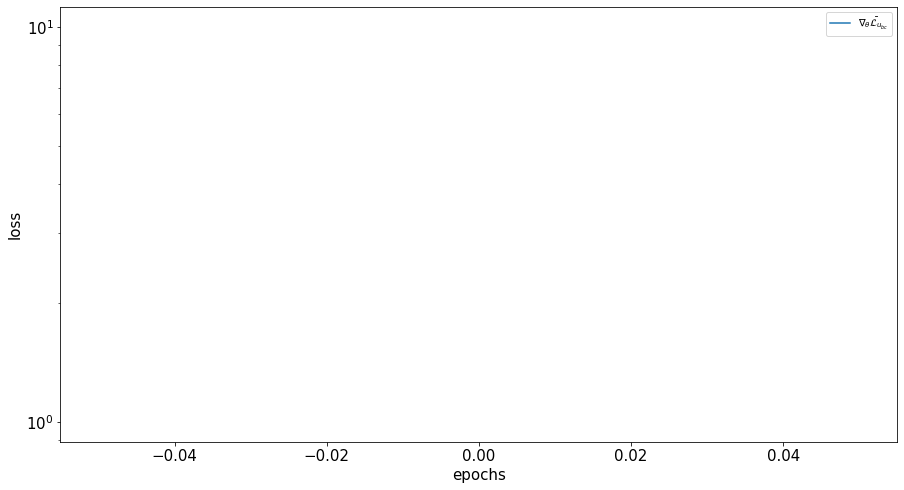

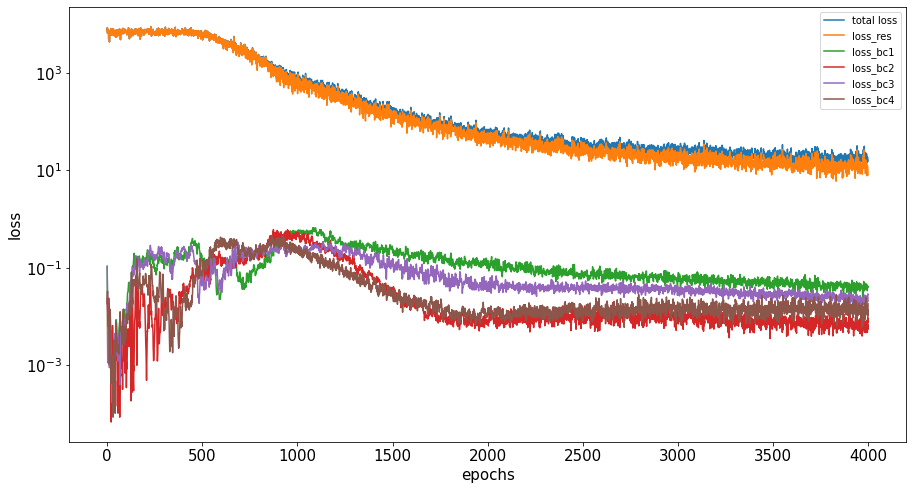

In [10]:

################################################################################################


nIter =4001
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 128

a_1 = 1
a_2 = 4

# Parameter
lam = 1.0

# Domain boundaries
bc1_coords = np.array([[-1.0, -1.0], [1.0, -1.0]])
bc2_coords = np.array([[1.0, -1.0], [1.0, 1.0]])
bc3_coords = np.array([[1.0, 1.0], [-1.0, 1.0]])
bc4_coords = np.array([[-1.0, 1.0], [-1.0, -1.0]])

dom_coords = np.array([[-1.0, -1.0], [1.0, 1.0]])


# Train model

# Test data
nn = 100
x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
x1, x2 = np.meshgrid(x1, x2)
X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))




# Exact solution
u_star = u(X_star, a_1, a_2)
f_star = f(X_star, a_1, a_2, lam)

# Create initial conditions samplers
ics_sampler = None

# Define model
mode = 'M2'            # Method: 'M1', 'M2', 'M3', 'M4'
stiff_ratio = False    # Log the eigenvalues of Hessian of losses

layers = [2, 50, 50, 50, 1]


iterations = 1
methods = ["mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    error_f_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))


        # Create boundary conditions samplers
        bc1 = Sampler(2, bc1_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC1')
        bc2 = Sampler(2, bc2_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC2')
        bc3 = Sampler(2, bc3_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC3')
        bc4 = Sampler(2, bc4_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC4')
        bcs_sampler = [bc1, bc2, bc3, bc4]

        # Create residual sampler
        res_sampler = Sampler(2, dom_coords, lambda x: f(x, a_1, a_2, lam), name='Forcing')

        # [elapsed, error_u , error_f ,  mode] = test_method(mtd , layers, operator, ics_sampler, bcs_sampler , res_sampler ,lam , mode , 
        #                                                                stiff_ratio , X_star ,u_star , f_star , nIter ,bcbatch_size , bcbatch_size , ubatch_size)

#test_method(mtd , layers, operator, ics_sampler, bcs_sampler , res_sampler ,lam , mode , stiff_ratio , X_star ,u_star , f_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size)


        tf.reset_default_graph()
        gpu_options = tf.GPUOptions(visible_device_list="0")
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
            model = Helmholtz2D(layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, sess)
 #def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, sess)
            # Train model
            start_time = time.time()

            if mtd =="full_batch":
                model.train(nIter  ,bcbatch_size , ubatch_size )
            elif mtd =="mini_batch":
                model.trainmb(nIter, batch_size=mbbatch_size )
            else:
                print("unknown method!")
            elapsed = time.time() - start_time


            # Predictions
            u_pred = model.predict_u(X_star)
            f_pred = model.predict_r(X_star)

            # Relative error
            error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
            error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

            print('Relative L2 error_u: {:.2e}'.format(error_u))
            print('Relative L2 error_f: {:.2e}'.format(error_f))

            model.plot_grad()
            model.save_NN()
            model.plt_prediction( x1 , x2 , X_star , u_star , u_pred , f_star , f_pred)

            model.print("average lambda_bc" , np.average(model.adpative_constant_log))
            model.print("average lambda_res" , str(1.0))
            # sess.close()  

            time_list.append(elapsed)
            error_u_list.append(error_u)
            error_f_list.append(error_f)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    print("average of error_v_list:" , sum(error_f_list) / len(error_f_list) )

    result_dict[mtd] = [time_list ,error_u_list ,error_f_list ]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

scipy.io.savemat("./M1_dataset/NS_model_"+mode+"_result_mb"+str(bcbatch_size)+"_fb"+str(ubatch_size)+"_"+str(bcbatch_size)+"_"+str(iterations)+".mat" , result_dict)




In [ ]:
#### database is a vailable

In [4]:
### Plot ###

# Exact solution & Predicted solution
# Exact soluton
U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

# Predicted solution
U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(x1, x2, U_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Exact $u(x)$')

plt.subplot(1, 3, 2)
plt.pcolor(x1, x2, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Predicted $u(x)$')

plt.subplot(1, 3, 3)
plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

# Residual loss & Boundary loss
loss_res = mode.loss_res_log
loss_bcs = mode.loss_bcs_log

fig_2 = plt.figure(2)
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(loss_res, label='$\mathcal{L}_{r}$')
ax.plot(loss_bcs, label='$\mathcal{L}_{u_b}$')
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Adaptive Constant
adaptive_constant = mode.adpative_constant_log

fig_3 = plt.figure(3)
ax = fig_3.add_subplot(1, 1, 1)
ax.plot(adaptive_constant, label='$\lambda_{u_b}$')
ax.set_xlabel('iterations')
plt.legend()
plt.tight_layout()
plt.show()

# Gradients at the end of training
data_gradients_res = mode.dict_gradients_res_layers
data_gradients_bcs = mode.dict_gradients_bcs_layers

gradients_res_list = []
gradients_bcs_list = []

num_hidden_layers = len(layers) - 1
for j in range(num_hidden_layers):
    gradient_res = data_gradients_res['layer_' + str(j + 1)][-1]
    gradient_bcs = data_gradients_bcs['layer_' + str(j + 1)][-1]

    gradients_res_list.append(gradient_res)
    gradients_bcs_list.append(gradient_bcs)

cnt = 1
fig_4 = plt.figure(4, figsize=(13, 4))
for j in range(num_hidden_layers):
    ax = plt.subplot(1, 4, cnt)
    ax.set_title('Layer {}'.format(j + 1))
    ax.set_yscale('symlog')
    gradients_res = data_gradients_res['layer_' + str(j + 1)][-1]
    gradients_bcs = data_gradients_bcs['layer_' + str(j + 1)][-1]
    sns.distplot(gradients_bcs, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \lambda_{u_b} \mathcal{L}_{u_b}$')
    sns.distplot(gradients_res, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \mathcal{L}_r$')
    
    ax.get_legend().remove()
    ax.set_xlim([-3.0, 3.0])
    ax.set_ylim([0,100])
    cnt += 1
handles, labels = ax.get_legend_handles_labels()
fig_4.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.01),
            borderaxespad=0, bbox_transform=fig_4.transFigure, ncol=2)
plt.tight_layout()
plt.show()

# Eigenvalues if applicable
if stiff_ratio:
    eigenvalues_list = mode.eigenvalue_log
    eigenvalues_bcs_list = mode.eigenvalue_bcs_log
    eigenvalues_res_list = mode.eigenvalue_res_log
    eigenvalues_res = eigenvalues_res_list[-1]
    eigenvalues_bcs = eigenvalues_bcs_list[-1]

    fig_5 = plt.figure(5)
    ax = fig_5.add_subplot(1, 1, 1)
    ax.plot(eigenvalues_res, label='$\mathcal{L}_r$')
    ax.plot(eigenvalues_bcs, label='$\mathcal{L}_{u_b}$')
    ax.set_xlabel('index')
    ax.set_ylabel('eigenvalue')
    ax.set_yscale('symlog')
    plt.legend()
    plt.tight_layout()
    plt.show()

    

NameError: name 'u_pred' is not defined